[2.65942893 0.61006697 0.17776304]


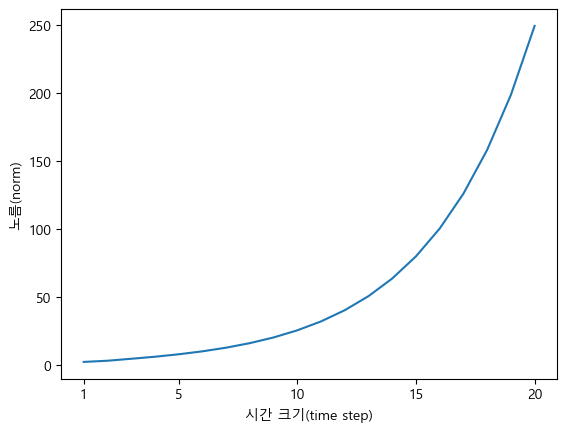

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

N=2
H=3
T=20

dh=np.ones((N,H))
np.random.seed(3)
Wh=np.random.randn(H,H)

norm_list=[]
for t in range(T):
    dh=np.matmul(dh, Wh.T)
    norm=np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

u, s, vh = np.linalg.svd(Wh)
print(s)

# 그래프 그리기   : 기울기 폭발
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

[1.32971447 0.30503349 0.08888152]


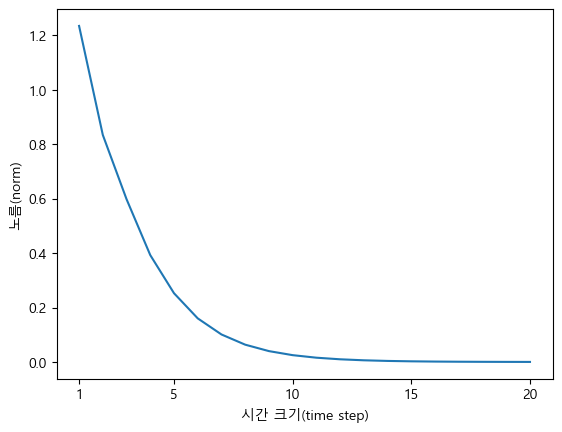

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


N = 2  # 미니배치 크기
H = 3  # hidden state 벡터의 차원 수
T = 20  # 시계열 데이터의 길이(= timestep)

dh = np.ones((N, H))
np.random.seed(3)
# Wh = np.random.randn(H, H) 
Wh = np.random.randn(H, H) * 0.5                # 여기가 차이점.

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
u, s, vh = np.linalg.svd(Wh)
print(s)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

In [ ]:
import numpy as np

dW1=np.random.rand(3,3)*10
dW2=np.random.rand(3,3)*10

grads=[dW1,dW2]
max_norm=5.0                                #threshold

def clip_grads(grads,max_norm):
    total_norm=0
    for grad in grads:
        total_norm+=np.sum(grad**2)
    total_norm=np.sqrt(total_norm)

    rate=max_norm/(total_norm+1e-6)
    if rate<1:
        for grad in grads:
            grad*=rate

In [ ]:
# LSTM 클래스를 구현해보자.
import sys
sys.path.append('..')
from common.np import *
from common.layers import *
from common.functions import sigmoid



class LSTM:
    def __init__(self, Wh, Wx, b):
        self.params=[Wh,Wx,b]                       # 각각 4개 분의 가중치를 저장함. 예를들어 Wh의 경우 [Wh_f, Wh_g, Wh_i, Wh_o]
        self.grads=[np.zeros_like(Wh), np.zeros_like(Wx), np.zeros_like(b)]
        self.cache=None                             # 순전파 때 중간결과를 보관했다가 역전파 계싼에 사용하려는 용도의 인스턴스 변수

    def forward(self, x, h_prev, c_prev):
        Wh, Wx, b=self.params
        N,H=h_prev.shape                            #h_(t-1)

        A=np.matmul(x,Wx)+np.matmul(h_prev,Wh)+b    #affine을 한꺼번에 함.

        #slice
        f=A[:,:H]
        g=A[:,H:2*H]
        i=A[:,2*H:3*H]
        o=A[:,3*H:]

        f=sigmoid(f)
        g=np.tanh(g)
        i=sigmoid(i)
        o=sigmoid(o)

        c_next=f*c_prev+g*i
        h_next=o*np.tanh(c_next)

        self.cache=(x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)       # dc_next임.
        
        dc_prev = ds * f                                            
        
        di = ds * g                                                 
        df = ds * c_prev                                            
        do = dh_next * tanh_c_next                                  
        dg = ds * i                                                 
        
        di *= i * (1 - i)                                           #sigmoid의 backpropagation은 y(1-y)다. 그리고 기존의 기울기에 곱해줘야한다.
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)                                          #tanh의 backpropagation은 (1-y**2)
        
        dA = np.hstack((df, dg, di, do))                            #hstack은 column들을 가로로 연결한다.(붙인다)
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)                                         #repeat의 역전파는 더하기다.
        
        self.grads[0][...] = dWx                                    #깊은 복사.
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev


In [ ]:
#역전파에서 slice노드의 역전파는 어케함?
dA=np.hstack((df,dg,di,do))                       #각각의 역전파들을 가로로 결합하면 된다.

NameError: name 'df' is not defined

In [ ]:
# 이번에는 TimeLSTM을 구현해보자.

class TimeLSTM:                                             #Time시퀀스가 존재.
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeors_like(Wx), np.zeors_like(Wh), np.zeros_like(b)]
        self.layers=None
        self.h,self.c=None, None                  #은닉상태와 기억셀을 인스턴스 변수로 유지한다. 왜냐하면 forward가 불렸을 때 이전 시각의 은닉상태(와 기억셀)에서 시작가능.
        self.dh=None
        self.stateful=stateful

    def forward(self, xs):
        Wx, Wh, b=self.params
        N, T, D=xs.shape
        H=Wh.shape[0]                             # Wh는 shape이 H x H

        self.layers=[]
        hs=np.empty((N,T,H), dtype='f')

        if not self.stateful or self.h is None:             #stateful이 false거나 self.h가 없을 때 self.h를 0행렬로 만든다.
            self.h=np.zeros((N,H), dtype='f')
        if not self.stateful or self.c is None:
            self.c=np.zeros((N,H), dtype='f')

        for t in range(T):
            layer=LSTM(*self.params)
            self.h, self.c=layer.forward(xs[:,t,:], self.h, self.c)                      
            hs[:,t,:]=self.h
            
            self.layers.append(layer)

        return hs
    
    def backward(self, dhs):
        Wx, Wh, b=self.params
        N,T,H=dhs.shape
        D=Wx.shape[0]           # x가 (N,T,D) N x D 이고 Wx는 D x H

        dxs=np.empty((N,T,D),dtype='f')
        dh, dc=0, 0                             #dh_next와 dc_next
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad                 #모두 같은 가중치를 사용하므로 더해준다.

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):              # TimeLSTM 네트워크의 은닉 상태(h)와 셀 상태(c)를 수동으로 설정하는 매서드
        self.h, self.c = h, c                    # 이전 타임스텝의 은닉상태와 기억셀이 되어 그다음 lstm으로 넘어간다.

    def reset_state(self):                       #신경망의 상태를 초기화하는 매서드.
        self.h, self.c = None, None

In [1]:
# chap06/rnnlm.py
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')       #XAVIER 초기화화
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9998.86
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2724.80
| 에폭 1 |  반복 41 / 1327 | 시간 6[s] | 퍼플렉서티 1231.00
| 에폭 1 |  반복 61 / 1327 | 시간 8[s] | 퍼플렉서티 975.45
| 에폭 1 |  반복 81 / 1327 | 시간 11[s] | 퍼플렉서티 797.84
| 에폭 1 |  반복 101 / 1327 | 시간 14[s] | 퍼플렉서티 648.67
| 에폭 1 |  반복 121 / 1327 | 시간 17[s] | 퍼플렉서티 641.75
| 에폭 1 |  반복 141 / 1327 | 시간 20[s] | 퍼플렉서티 602.60
| 에폭 1 |  반복 161 / 1327 | 시간 23[s] | 퍼플렉서티 571.22
| 에폭 1 |  반복 181 / 1327 | 시간 25[s] | 퍼플렉서티 591.52
| 에폭 1 |  반복 201 / 1327 | 시간 28[s] | 퍼플렉서티 498.55
| 에폭 1 |  반복 221 / 1327 | 시간 31[s] | 퍼플렉서티 494.30
| 에폭 1 |  반복 241 / 1327 | 시간 34[s] | 퍼플렉서티 443.14
| 에폭 1 |  반복 261 / 1327 | 시간 37[s] | 퍼플렉서티 465.67
| 에폭 1 |  반복 281 / 1327 | 시간 39[s] | 퍼플렉서티 449.03
| 에폭 1 |  반복 301 / 1327 | 시간 42[s] | 퍼플렉서티 396.09
| 에폭 1 |  반복 321 / 1327 | 시간 45[s] | 퍼플렉서티 344.23
| 에폭 1 |  반복 341 / 1327 | 시간 48[s] | 퍼플렉서티 397.27
| 에폭 1 |  반복 361 / 1327 | 시간 51[s] | 퍼플렉서티 403.28
| 에폭 1 |  반복 381 / 1327 | 시간 54[s] | 퍼플렉서티 332.45
| 에폭 1 

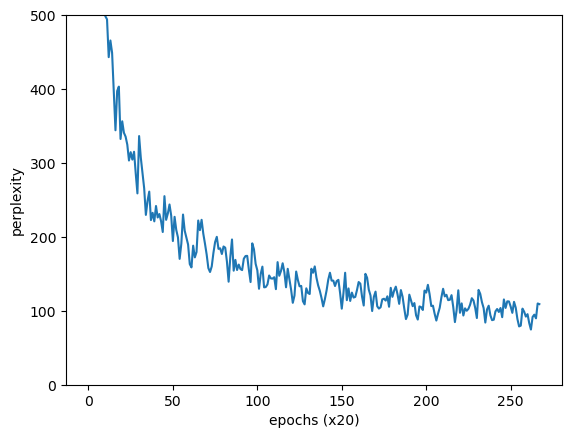

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  136.49549180608403


In [1]:

# chap06/train_rnnlm.py
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]                    # 마지막 단어를 제외한 모든 단어들로 구성
ts = corpus[1:]                     # 첫 번째 단어를 제외한 나머지 단어들로 구성

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

# RNNLM 추가 개선

LSTM 계층 다층화--> 정확도를 높일 수 있다. 표현력도 올라간다.

하지만 층이 깊어지면 오벌피팅이 발생함. 이러한 오버피팅을 방지를 하려면 --> 훈련데이터 양 늘리기, 모델 복잡도 줄이기(such as 정규화, 예를 들어 L2정규화, 드롭아웃)

근데 드롭아웃을 적용할 때 시간축 방향보다 깊이 방향으로 적용하는 것이 효과가 좋다.

하지만 시간축으로 드롭아웃을 적용하는 방법이 있는데 이는 변형 드롭아웃으로 효과가 깊이방향으로만 드롭아웃을 적용하는 것보다 좋다.

그리고 가중치공유: embedding 가중치(VxH)와 affine가중치(HxV, 임베딩 가중치의 전치)를 공유(V는 어휘 수, H는 은닉상태 차원수)

## 따라서 LSTM 계층 다층화, 드롭아웃, 가중치 공유를 통해 개선 가능.


In [ ]:

#참고. dropout코드

import numpy as np

class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        # 드롭아웃 비율을 설정합니다.
        self.params, self.grads = [], []  # 파라미터와 기울기를 저장할 리스트 초기화
        self.dropout_ratio = dropout_ratio  # 드롭아웃 비율
        self.mask = None  # 마스크는 드롭아웃을 적용할 때 사용되는 행렬입니다.
        self.train_flg = True  # 학습 여부를 나타내는 플래그 (학습 중이면 드롭아웃 적용)

    def forward(self, xs):
        """
        순전파에서 드롭아웃을 적용하는 함수.
        
        xs: 입력 배열 (예: RNN의 출력값)
        """
        if self.train_flg:
            # 학습 중일 때만 드롭아웃을 적용합니다.
            # xs.shape의 크기만큼 난수를 생성하여 dropout_ratio보다 큰 값만 True로 설정
            flg = np.random.rand(*xs.shape) > self.dropout_ratio  


            #드롭아웃은 입력값의 일부 뉴런을 무작위로 0으로 만들어 학습 중에 과적합을 방지하는 기법입니다. 
            #드롭아웃이 적용되면 일부 뉴런들이 "비활성화"되기 때문에, 전체 네트워크의 출력을 그대로 사용하면 출력이 평균적으로 감소
            
            # scale은 드롭아웃 비율에 따라 출력을 조정하기 위한 값
            scale = 1 / (1.0 - self.dropout_ratio)  #드롭아웃으로 인해 출력값이 감소하는 효과를 보정하기 위함입니다. 
                                                    #즉, 드롭아웃을 적용했을 때 출력값의 크기가 감소하는 것을 원래 크기로 복원
            
            # 마스크를 생성하여 dropout을 적용한 후 scale 값을 곱하여 출력값을 조정
            self.mask = flg.astype(np.float32) * scale  # 드롭아웃 마스크

            # 입력 값에 마스크를 곱하여 드롭아웃을 적용한 결과를 반환
            return xs * self.mask
        else:
            # 학습이 아닐 때는 드롭아웃을 적용하지 않음
            return xs

    def backward(self, dout):
        """
        역전파에서 기울기를 마스크와 함께 조정하는 함수.
        
        dout: 다음 층으로 전달된 기울기 (역전파된 오차)
        """
        # 마스크와 역전파된 기울기를 곱하여 드롭아웃을 적용한 기울기를 반환
        return dout * self.mask

In [7]:
#better_rnnlm.py

import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.
     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!! 가중치 공유유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):             # 손실함수 계산 전까지 forward를 해준다.
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


# 계층 다층화, 드롭아웃(깊이방향), 가중치 공유가 모두 이루어졌다.

학습시켜보자. 근데 학습률 감소를 적용시켜보자.

### 1. 학습률 감소 (Learning Rate Decay)
학습률 감소는 훈련 중에 학습률을 점차적으로 낮추는 방법입니다. 보통 퍼플렉시티와 같은 검증 지표가 더 이상 향상되지 않거나 악화될 때 학습률을 낮추어 모델이 안정적으로 수렴하도록 돕습니다.
일반적으로 학습률을 일정 에폭마다 일정 비율로 줄이거나, 검증 성능(예: 퍼플렉시티)이 개선되지 않으면 학습률을 자동으로 감소시킵니다.



In [9]:
%matplotlib inline
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 3
max_grad = 0.25         #grad clipping을 위한 threshold
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 10000.15
| 에폭 1 |  반복 21 / 1327 | 시간 30[s] | 퍼플렉서티 4233.21
| 에폭 1 |  반복 41 / 1327 | 시간 57[s] | 퍼플렉서티 1856.32
| 에폭 1 |  반복 61 / 1327 | 시간 84[s] | 퍼플렉서티 1354.28
| 에폭 1 |  반복 81 / 1327 | 시간 113[s] | 퍼플렉서티 1014.40
| 에폭 1 |  반복 101 / 1327 | 시간 147[s] | 퍼플렉서티 842.97
| 에폭 1 |  반복 121 / 1327 | 시간 180[s] | 퍼플렉서티 782.99
| 에폭 1 |  반복 141 / 1327 | 시간 207[s] | 퍼플렉서티 726.95
| 에폭 1 |  반복 161 / 1327 | 시간 235[s] | 퍼플렉서티 661.35
| 에폭 1 |  반복 181 / 1327 | 시간 262[s] | 퍼플렉서티 666.86
| 에폭 1 |  반복 201 / 1327 | 시간 288[s] | 퍼플렉서티 565.46
| 에폭 1 |  반복 221 / 1327 | 시간 314[s] | 퍼플렉서티 570.44
| 에폭 1 |  반복 241 / 1327 | 시간 339[s] | 퍼플렉서티 505.21
| 에폭 1 |  반복 261 / 1327 | 시간 364[s] | 퍼플렉서티 541.04
| 에폭 1 |  반복 281 / 1327 | 시간 390[s] | 퍼플렉서티 512.43
| 에폭 1 |  반복 301 / 1327 | 시간 415[s] | 퍼플렉서티 438.58
| 에폭 1 |  반복 321 / 1327 | 시간 442[s] | 퍼플렉서티 384.51
| 에폭 1 |  반복 341 / 1327 | 시간 468[s] | 퍼플렉서티 451.24
| 에폭 1 |  반복 361 / 1327 | 시간 495[s] | 퍼플렉서티 457.45
| 에폭 1 |  반복 381 / 1327 | 시간 52

KeyboardInterrupt: 